# Setup

## Imports

In [197]:
import os

In [198]:
import numpy as np
import pandas as pd

In [199]:
import matplotlib
from matplotlib import patheffects
import matplotlib.pyplot as plt
import seaborn as sns

## Parameters

In [200]:
keys = [
    'Bacon2019',
    'hafenLowredshiftLymanLimit2017',
    'Imeletal2022',
    'Ololube2012',
    'Torres2013',
    'West2003',
]
key = keys[1]
librarian = 'S2'
vectorizer = 'SciBERT'
split_at_median = False
quantile = 0.1

density_quantile = quantile
edginess_quantile = quantile

In [201]:
# TODO: we can simplify all this param sweeping logic via analysis_data/all_data.csv
key_to_field = {
    'Bacon2019': 'Philosophy',
    'hafenLowredshiftLymanLimit2017': 'Physics',
    'Imeletal2022': 'Linguistics',
    'Ololube2012': 'Education',
    'Torres2013': 'Medicine',
    'West2003': 'Economics',
}

## Process Parameters

In [202]:
directory = os.path.join(
    '../../outputs',
    f'librarian={librarian}',
    f'vectorizer={vectorizer}',
)

# Data Preprocessing

In [203]:
dfs = []
for key in keys:
    fp = os.path.join(directory, f'center={key}/all_data.csv')
    df = pd.read_csv(fp)

    # Density categorization
    if split_at_median:
        med_density = df['density'].median()
        df['density_cat'] = (df['density'] > med_density).astype('category')
        df['density_cat'] = df['density_cat'].cat.rename_categories({
            True: 'upper',
            False: 'lower',
        })
    else:
        upper_quantile = df['density'].quantile(1 - density_quantile)
        lower_quantile = df['density'].quantile(density_quantile)
        df['density_cat'] = 'center'
        df.loc[df['density'] < lower_quantile, 'density_cat'] = 'lower'
        df.loc[df['density'] > upper_quantile, 'density_cat'] = 'upper'
        df = df.loc[df['density_cat'] != 'center']
        df['density_cat'] = df['density_cat'].astype('category')

    # Center category
    df['center'] = key
    df['field'] = key_to_field[key]

    dfs.append(df)

In [204]:
# Combine
df = pd.concat(dfs)

In [205]:
# Make a combined category
df['label'] = (
    df['center'].astype(str) + '_' + df['density_cat'].astype(str)
).astype('category')

In [206]:
# Make a log scale version
df['log_cpy'] = np.log10(df['citations_per_year'])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [207]:
# why are there duplicates?
# df = df[~df.index.duplicated()]
print(len(df[df.index.duplicated()]))
df = df.reset_index()
print(len(df[df.index.duplicated()]))

31439
0


# Visualization

/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_22648/3544781035.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_center_by_density = df_center.groupby('density_cat')


Median fraction change: 0.94
Median std fraction change: 0.82



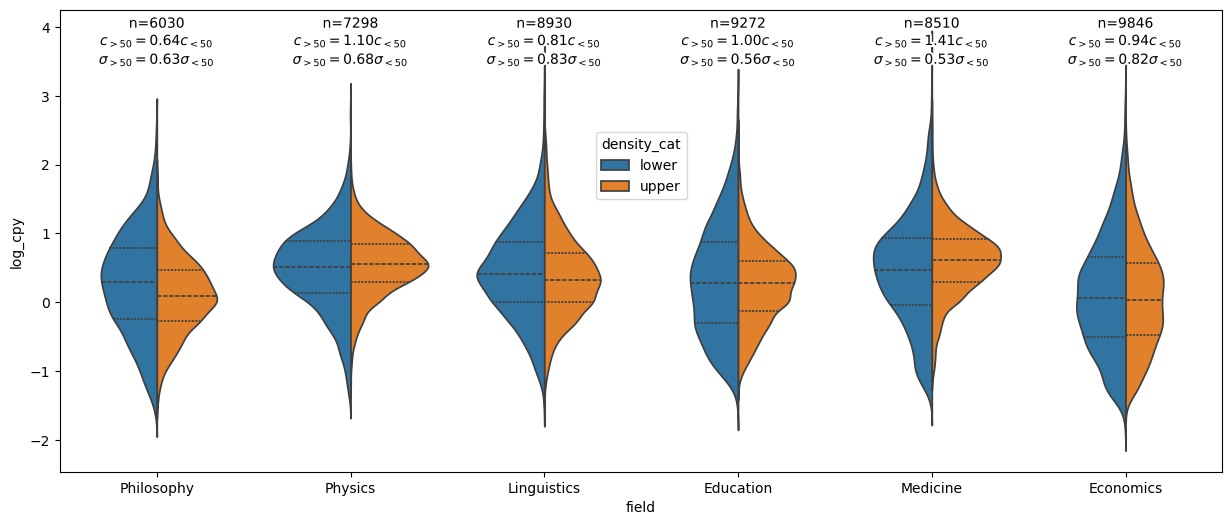

In [208]:
import matplotlib.transforms


fig = plt.figure(figsize=(len(keys) * 2.5, 6))
ax = plt.gca()

sns.violinplot(
    ax=ax,
    data=df,
    # x='center',
    x='field',
    y='log_cpy',
    hue='density_cat',
    split=True,
    inner='quart',
    dodge=True,
    gap=0,
)

df_by_center = df.groupby('center')
fraction_changes = []
fraction_std_changes = []
for i, key in enumerate(keys):

    # Get the group
    df_center = df_by_center.get_group(key)
    n = df_center.shape[0]

    # Median change
    df_center_by_density = df_center.groupby('density_cat')
    med_cpy = 10.**df_center_by_density['log_cpy'].median()
    fraction_change = med_cpy['upper'] / med_cpy['lower']
    fraction_changes.append(fraction_change)
    median_change_str = (
        r'$c_{>50} = '
        f'{fraction_change:.2f}'
        r'c_{<50}$'
    )

    # Median change in width
    std_cpy = 10.**df_center_by_density['log_cpy'].std()
    fraction_std_change = std_cpy['upper'] / std_cpy['lower']
    fraction_std_changes.append(fraction_std_change)
    std_change_str = (
        r'$\sigma_{>50} = '
        f'{fraction_std_change:.2f}'
        r'\sigma_{<50}$'
    )

    text = ax.annotate(
        text=f'n={n}\n' + median_change_str + '\n' + std_change_str,
        xy=(i, 1),
        xycoords=matplotlib.transforms.blended_transform_factory(
            ax.transData,
            ax.transAxes,
        ),
        xytext=(0, -5),
        textcoords='offset points',
        ha='center',
        va='top',
    )
    text.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='w'),
        patheffects.Normal()
    ])

legend = ax.get_legend()
legend.set_loc('upper center')
legend.set_bbox_to_anchor((0.5, 0.75))
legend.set_alignment('left')

print(
    f'Median fraction change: {np.median(fraction_change):.2f}\n'
    f'Median std fraction change: {np.median(fraction_std_change):.2f}\n'
)

## Edginess?

/Users/nathanielimel/miniforge3/envs/citesim/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/3z/q1pyp9n929z2nh_1_69s7y_40000gn/T/ipykernel_22648/1834724910.py:74: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_center_by_edginess = df_center.groupby('edginess_cat')


Median fraction change: 1.00
Median std fraction change: 1.16



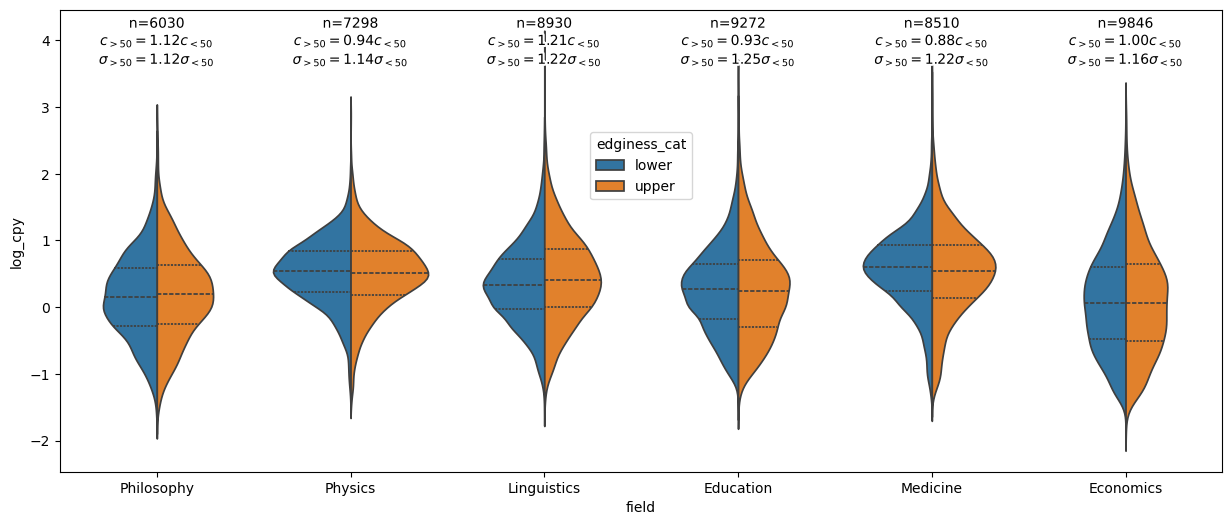

In [209]:
dfs = []
for key in keys:
    fp = os.path.join(directory, f'center={key}/all_data.csv')
    df = pd.read_csv(fp)

    # Density categorization
    if split_at_median:
        med_edginess = df['edginess'].median()
        df['edginess_cat'] = (df['edginess'] > med_edginess).astype('category')
        df['edginess_cat'] = df['edginess_cat'].cat.rename_categories({
            True: 'upper',
            False: 'lower',
        })
    else:
        upper_quantile = df['edginess'].quantile(1 - edginess_quantile)
        lower_quantile = df['edginess'].quantile(edginess_quantile)
        df['edginess_cat'] = 'center'
        df.loc[df['edginess'] < lower_quantile, 'edginess_cat'] = 'lower'
        df.loc[df['edginess'] > upper_quantile, 'edginess_cat'] = 'upper'
        df = df.loc[df['edginess_cat'] != 'center']
        df['edginess_cat'] = df['edginess_cat'].astype('category')

    # Center category
    df['center'] = key
    df['field'] = key_to_field[key]

    dfs.append(df)

# Combine
df = pd.concat(dfs)    


# Make a combined category
df['label'] = (
    df['center'].astype(str) + '_' + df['edginess_cat'].astype(str)
).astype('category')


# Make a log scale version
df['log_cpy'] = np.log10(df['citations_per_year'])
df['log_cpy'] = df['log_cpy'].replace(-np.inf, np.nan)

df = df.reset_index()




fig = plt.figure(figsize=(len(keys) * 2.5, 6))
ax = plt.gca()

sns.violinplot(
    ax=ax,
    data=df,
    # x='center',
    x='field',
    y='log_cpy',
    hue='edginess_cat',
    split=True,
    inner='quart',
    dodge=True,
    gap=0,
)

df_by_center = df.groupby('center')
fraction_changes = []
fraction_std_changes = []
for i, key in enumerate(keys):

    # Get the group
    df_center = df_by_center.get_group(key)
    n = df_center.shape[0]

    # Median change
    df_center_by_edginess = df_center.groupby('edginess_cat')
    med_cpy = 10.**df_center_by_edginess['log_cpy'].median()
    fraction_change = med_cpy['upper'] / med_cpy['lower']
    fraction_changes.append(fraction_change)
    median_change_str = (
        r'$c_{>50} = '
        f'{fraction_change:.2f}'
        r'c_{<50}$'
    )

    # Median change in width
    std_cpy = 10.**df_center_by_edginess['log_cpy'].std()
    fraction_std_change = std_cpy['upper'] / std_cpy['lower']
    fraction_std_changes.append(fraction_std_change)
    std_change_str = (
        r'$\sigma_{>50} = '
        f'{fraction_std_change:.2f}'
        r'\sigma_{<50}$'
    )

    text = ax.annotate(
        text=f'n={n}\n' + median_change_str + '\n' + std_change_str,
        xy=(i, 1),
        xycoords=matplotlib.transforms.blended_transform_factory(
            ax.transData,
            ax.transAxes,
        ),
        xytext=(0, -5),
        textcoords='offset points',
        ha='center',
        va='top',
    )
    text.set_path_effects([
        patheffects.Stroke(linewidth=3, foreground='w'),
        patheffects.Normal()
    ])

legend = ax.get_legend()
legend.set_loc('upper center')
legend.set_bbox_to_anchor((0.5, 0.75))
legend.set_alignment('left')

print(
    f'Median fraction change: {np.median(fraction_change):.2f}\n'
    f'Median std fraction change: {np.median(fraction_std_change):.2f}\n'
)